#### RBG image and pixel scale

Andressa Wille

andressaw2@gmail.com

14/01/2026

* This is a tutorial for creating an RGB image with a size scale. We are using three HST filters with an image of the jellyfish galaxy Abell 2744.

Imports:

In [1]:
import numpy as np
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy import wcs
from matplotlib import pyplot as plt
from astropy.cosmology import LambdaCDM

Choose three filters to compose a RGB image:

In [2]:
r = fits.open('fits/F105W.fits')
g = fits.open('fits/F814W.fits')
b = fits.open('fits/F435W.fits')

In [3]:
galaxy_r = r[1].data 
galaxy_g = g[1].data
galaxy_b = b[1].data

(100.0, 550.0)

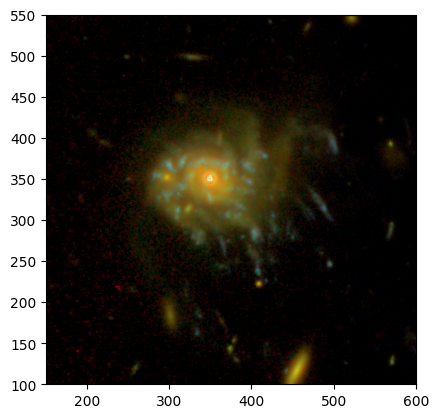

In [4]:
image_rgb = make_lupton_rgb(galaxy_r, galaxy_g, galaxy_b, stretch=0.5, Q=10)
plt.imshow(image_rgb, origin='lower')
plt.xlim(150., 600.)
plt.ylim(100., 550.)
#plt.savefig('F0083.png')

Read the header of one of the fits:

In [5]:
with fits.open('fits/F105W.fits') as hdul:
    hdul.info()
    hdr_p = hdul["PRIMARY"].header
    hdr_d = hdul[1].header
    imdata = hdul[1].data

    w = wcs.WCS(hdr_d, hdul)

Filename: fits/F105W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU        42   (701, 701)   float32   


In [6]:
hdr_d

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  701 / length of data axis 1                          
NAXIS2  =                  701 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BUNIT   = '10.0*nanoJansky'    / physical units                                 
                                                                                
                      / World Coordinate System (WCS)                           
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                2148. / Pixel coordinate of reference point            
CRPIX2  =                 25

In [7]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 3.5875  -30.3966667  
CRPIX : 2148.0  255.0  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.1111111111111e-05  1.1111111111111e-05  
NAXIS : 701  701

The product of PC and CDELT is what transforms pixels into physical coordinates. In this case, there is no rotation, so the values outside the main diagonal of the PC matrix are zero.

Calculate the pixel scale in arcsec/pixel. CDELT is in degrees:

In [8]:
pix_scale = np.abs(w.wcs.cdelt[0]) * 3600  #deg/pixel --> arcsec/pixel
pix_scale

0.0399999999999996

The angular size in arcseconds is the multiplication of a size in pixels by the arcsec/pixel scale. In this example, considering the IFU/GMOS of the Gemini Observatory, the pointings should have an angular size of 5'' by 7''. Therefore, in our image, we want to know the number of pixels that this corresponds to.

In [9]:
#angular_size_arcsec = size_pixels * pix_scale
#size_pixels = angular_size_arcsec/pix_scale
pixels_five_arcsec = 5/pix_scale
print(pixels_five_arcsec)

pixels_seven_arcsec = 7/pix_scale
print(pixels_seven_arcsec)

125.00000000000125
175.00000000000176


To obtain a spatial scale (size in kpc), we need some information. In this case, we only know the redshift of the galaxy (0.3033), and we want to know its distance. This astropy function returns the distance in Mpc:

UPDATE: Sorry, the function is wrong! The correct one is this: d = cosmo.angular_diameter_distance(z).

In [10]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
z = 0.3033
d = cosmo.comoving_distance(z)
print(d)

1206.5087006511849 Mpc


The size in kpc is the angular size in radians multiplied by the distance in kpc. So we have some conversions to do. The angular size is in arcsec, to convert to rad, we first convert to degrees (dividing by 3600) and then multiply by pi/180. The distance is in Mpc, to convert to kpc, we multiply by 1000.

Here's an example: let's say I want to draw a line with a length of 45 pixels. How much is that in kpc?

In [11]:
size_pixels = 45
angular_size_arcsec = size_pixels * pix_scale
print(angular_size_arcsec)
angular_size_rad = (angular_size_arcsec/3600) * np.pi/180
print(angular_size_rad)

d_Mpc = d.value
d_kpc = d_Mpc * 1000
print(d_kpc)
size_kpc = angular_size_rad * d_kpc
print(size_kpc)

1.7999999999999818
8.726646259971558e-06
1206508.700651185
10.528774640160806


Now another example: my line must be 10 kpc long. How many pixels does that represent?

In [12]:
size_kpc = 10
angular_size_rad = size_kpc/d_kpc
print(angular_size_rad)

angular_size_arcsec = (angular_size_rad * 3600) * 180/np.pi
print(angular_size_arcsec)

size_pixels = angular_size_arcsec/pix_scale
print(size_pixels)

8.288377858031801e-06
1.709600652989653
42.74001632474175


Let's make the RGB image, with RA and Dec, and with 5'' by 7'' pointings and a spatial scale of 10 kpc:

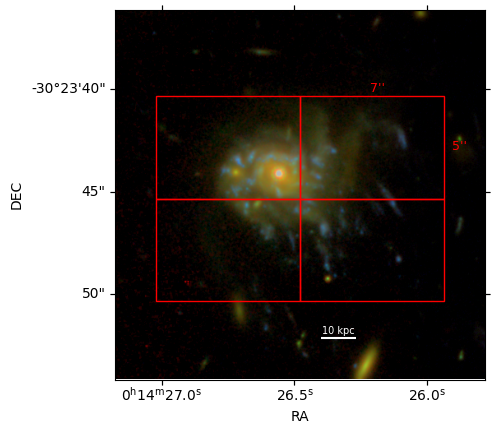

In [13]:
import matplotlib.patches as patches

forc=np.float_()

r_ = np.array(galaxy_r,forc)*1.1
g_ = np.array(galaxy_g,forc)*1.2
b_ = np.array(galaxy_b,forc)*1.6

t = 25
r_[r_ > t] = t
g_[g_ > t] = t
b_[b_ > t] = t

fig, ax = plt.subplots(subplot_kw={"projection": w})

image_rgb = make_lupton_rgb(r_, g_, b_, minimum=0,
                            stretch=0.8, Q=10)
plt.imshow(image_rgb, origin='lower')

ax.add_patch(patches.Rectangle((200, 320),pixels_seven_arcsec, pixels_five_arcsec, 
                      edgecolor='red', fill=False))

ax.add_patch(patches.Rectangle((200+pixels_seven_arcsec, 320),pixels_seven_arcsec, pixels_five_arcsec, 
                      edgecolor='red', fill=False))

ax.add_patch(patches.Rectangle((200+pixels_seven_arcsec, 320-pixels_five_arcsec),pixels_seven_arcsec, pixels_five_arcsec, 
                      edgecolor='red', fill=False))

ax.add_patch(patches.Rectangle((200, 320-pixels_five_arcsec),pixels_seven_arcsec, pixels_five_arcsec, 
                      edgecolor='red', fill=False))
plt.annotate("7''", xy=(460, 450), fontsize=9, color='red')
plt.annotate("5''", xy=(560, 380), fontsize=9, color='red')

plt.hlines(150, 400, 400+size_pixels, colors='white')
plt.annotate('10 kpc', xy=(402, 155), fontsize=7, color='white')
plt.xlim(150., 600.)
plt.ylim(100., 550.)

ra, dec = ax.coords["ra"], ax.coords["dec"]
ra.set_axislabel("RA")
dec.set_axislabel("DEC")

#plt.savefig('F0083_GMOS_Gemini.png')